<a href="https://colab.research.google.com/github/ggzone/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter12/Face_generation_using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
# !unzip -q male_female_face_images.zip
!pip install kagglehub


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashwingupta3012/male-and-female-faces-dataset")

print("Path to dataset files:", path)


100%|██████████| 1.63G/1.63G [00:14<00:00, 120MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashwingupta3012/male-and-female-faces-dataset/versions/1


In [7]:
!ls '/root/.cache/kagglehub/datasets/ashwingupta3012/male-and-female-faces-dataset/versions/1/Male and Female face dataset/'
!mv '/root/.cache/kagglehub/datasets/ashwingupta3012/male-and-female-faces-dataset/versions/1/Male and Female face dataset/Female Faces'  /content/females
!mv '/root/.cache/kagglehub/datasets/ashwingupta3012/male-and-female-faces-dataset/versions/1/Male and Female face dataset/Male Faces'  /content/males

'Female Faces'	'Male Faces'


In [8]:
!pip install -q --upgrade torch_snippets
from torch_snippets import *
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 97.4 MB/s eta 0:00:00


In [9]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [10]:
!mkdir cropped_faces
images = Glob('/content/females/*.jpg')+Glob('/content/males/*.jpg')
for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

In [11]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [13]:
from torch.utils.data import Dataset

class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

In [14]:
ds = Faces(folder='cropped_faces/')

In [16]:
from torch.utils.data import DataLoader


dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input): return self.model(input)

In [19]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,3,64,64));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input): return self.model(input)

In [21]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [22]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [24]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EPOCH: 1.000  d_loss: 0.488  g_loss: 18.628  (34.99s - 839.84s remaining)
EPOCH: 2.000  d_loss: 0.823  g_loss: 10.143  (68.40s - 786.60s remaining)
EPOCH: 3.000  d_loss: 0.517  g_loss: 8.025  (99.81s - 731.95s remaining)
EPOCH: 4.000  d_loss: 0.672  g_loss: 5.828  (135.01s - 708.78s remaining)
EPOCH: 5.000  d_loss: 0.576  g_loss: 6.273  (165.42s - 661.68s remaining)
EPOCH: 6.000  d_loss: 0.595  g_loss: 5.888  (200.86s - 636.04s remaining)
EPOCH: 7.000  d_loss: 0.440  g_loss: 5.881  (232.76s - 598.53s remaining)
EPOCH: 8.000  d_loss: 0.593  g_loss: 6.556  (264.35s - 561.75s remaining)
EPOCH: 9.000  d_loss: 0.477  g_loss: 5.378  (299.79s - 532.95s remaining)
EPOCH: 10.000  d_loss: 0.513  g_loss: 4.470  (330.63s - 495.95s remaining)
EPOCH: 11.000  d_loss: 0.516  g_loss: 4.988  (365.75s - 465.50s remaining)
EPOCH: 12.000  d_loss: 0.402  g_loss: 4.523  (398.84s - 432.07s remaining)
EPOCH: 13.000  d_loss: 0.452  g_loss: 4.571  (430.60s - 397.48s remaining)
EPOCH: 14.000  d_loss: 0.472  g_los

100%|██████████| 126/126 [00:00<00:00, 737.15it/s]


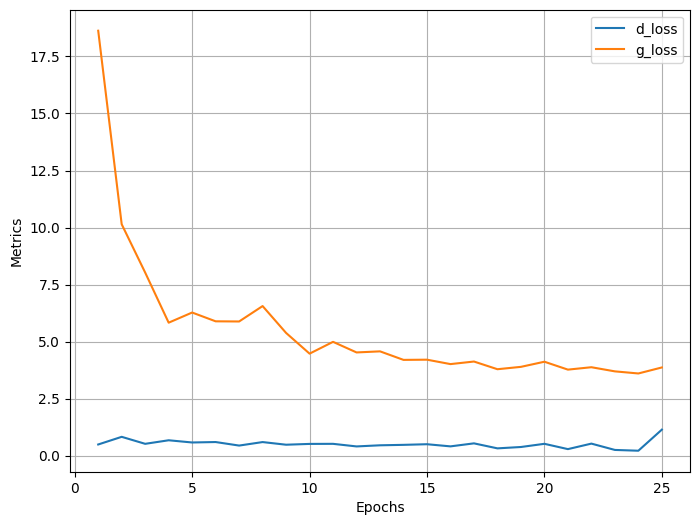

In [26]:
from torch_snippets.torch_loader import Report
log = Report(25)
for epoch in range(25):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

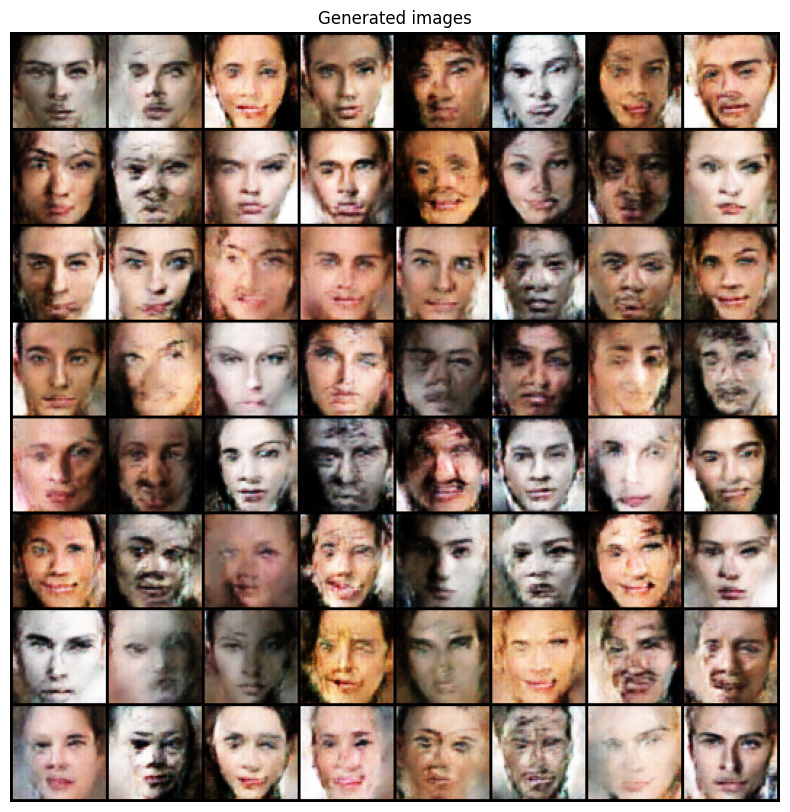

In [27]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')